In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

In [2]:
url_hockey = 'https://raw.githubusercontent.com/anyaweintraub/datasciencefoundationsA3/refs/heads/main/new%202.csv'
hockey_data = pd.read_csv(url_hockey,dtype={'Pos':'category'})

hockey_data = hockey_data[hockey_data['SOG'] >= hockey_data['G']].copy()

There was an ERROR!!!!! One player had one goal but had never shot on the goal. I removed that player from my data set.

In [3]:
hockey_data.reset_index(drop = True)

,Rk,Player,Age,Team,Pos,GP,G,A,PTS,SOG,-9999
0,1,Nathan MacKinnon,29.0,COL,C,79,32,84,116,320,mackina01
1,2,David Pastrňák,28.0,BOS,RW,82,43,63,106,319,pastrda01
2,3,Zach Werenski,27.0,CBJ,D,81,23,59,82,298,werenza01
3,4,Brady Tkachuk,25.0,OTT,LW,72,29,26,55,296,tkachbr01
4,5,Filip Forsberg,30.0,NSH,C,82,31,45,76,281,forsbfi01
...,...,...,...,...,...,...,...,...,...,...,...
1017,1019,Matt Villalta,25.0,UTA,G,1,0,0,0,0,villama01
1018,1020,Jesper Wallstedt,22.0,MIN,G,2,0,0,0,0,wallsje01
1019,1021,Scott Wedgewood,32.0,2TM,G,24,0,0,0,0,wedgesc01
1020,1022,Jack Williams,NaN,CBJ,F,1,0,0,0,0,willija02


# Context

For my project, I decided to look at the hierarchical model for the players of the 24-25 NHL season. I thought there might be some dependence on position in terms of the number of goal a player scores and the shots they have on the goal.

Hockey is a lovely sport that has different positions. There are forwards, often split between center, left wing, and right wing, but some players may just generally be forwards. There are defensemen and goalkeepers.

# Priors

<Axes: ylabel='G'>

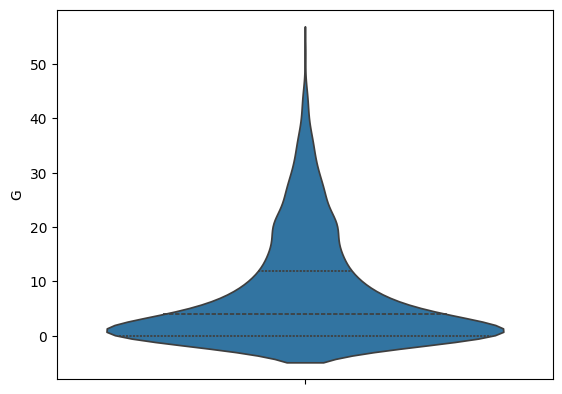

In [4]:
sns.violinplot(hockey_data.G,inner='quart')

<Axes: ylabel='SOG'>

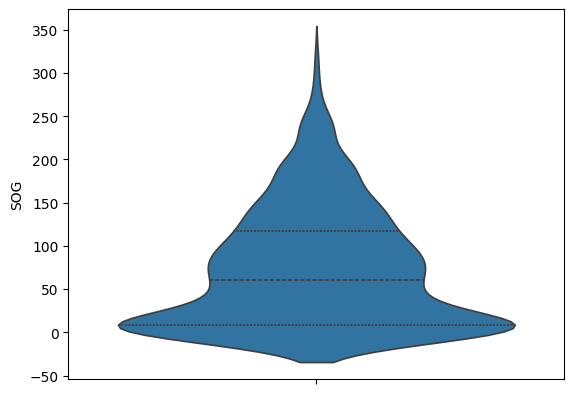

In [5]:
sns.violinplot(hockey_data.SOG,inner='quart')

I have chosen beta distribution for goals and gamma distribution for shots on goal, as they look quite similar to the side of the violin plot.

# Non-Hierarchical Model

I chose these values for alpha, beta, mu, and sigma based on the violin plots and where my heart lies <3.

In [6]:
pos_idx = hockey_data.Pos.cat.codes.values

pos_codes = hockey_data.Pos.cat.categories

hockey_coords = {"Pos":pos_codes}

In [7]:
print(len(hockey_data.SOG.values))

1022


In [8]:
print(len(hockey_data.G.values))

1022


In [ ]:
with pm.Model(coords=hockey_coords) as hockey_nh_model:
    μ = pm.Beta('μ', alpha = 10, beta = 70,
                      dims="Pos")
    ν = pm.Gamma('ν', mu = 100, sigma =50,
                      dims="Pos")

   # Parameter for players
    θ = pm.Beta('θ', mu = μ[pos_idx], nu = ν[pos_idx])

    #This tells our model how many SOG and goals each player has
    _ = pm.Binomial('gsog',
                    n = hockey_data.SOG.values,
                    p = θ,
                    observed = hockey_data.G.values)

    idata_hockey_nh = pm.sample(target_accept = 0.95)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

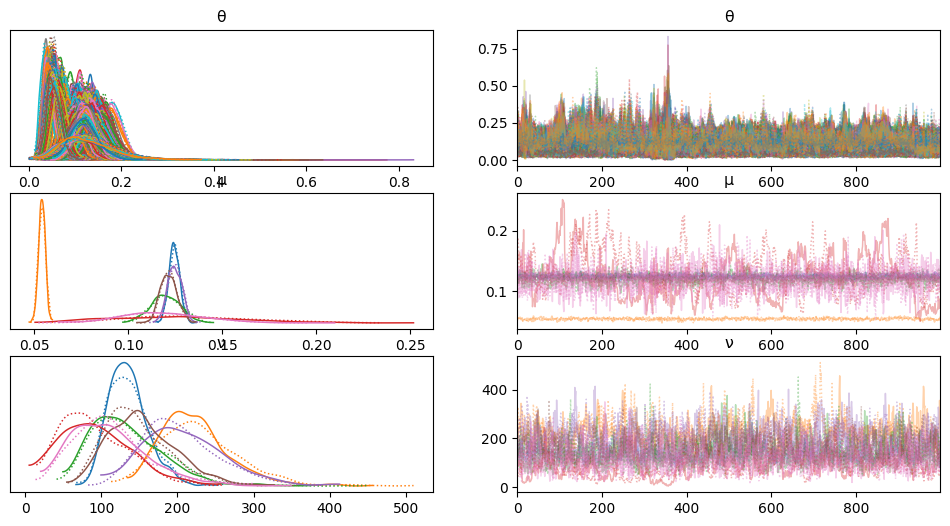

In [25]:
az.plot_trace(idata_hockey_nh)

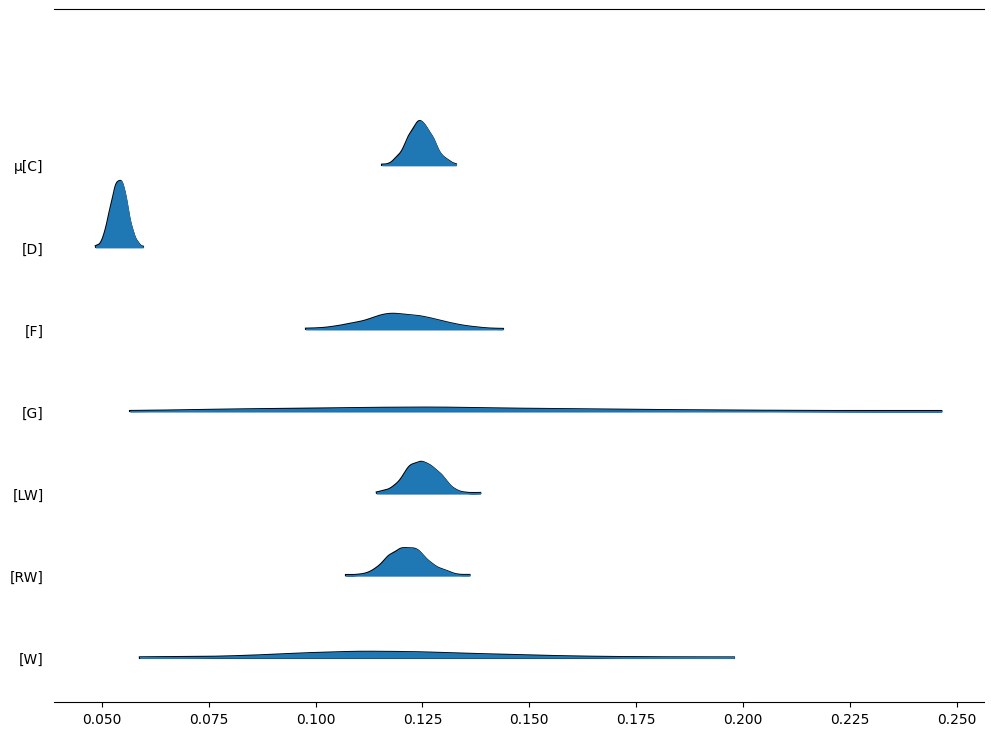

In [26]:
axes = az.plot_forest(idata_hockey_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.998)

# Hierarchical Model

In [ ]:
with pm.Model(coords = hockey_coords) as hockey_h_model:
    # Hyper parameters
    μ_mu = pm.Beta('μ_mu', alpha = 10, beta = 70)
    ν_nu = pm.Gamma('ν_nu', mu = 100, sigma =50)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ_mu, nu = ν_nu, dims = "Pos")
    ν_p = pm.Gamma('ν_p', mu = 100, sigma = 50, dims="Pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many SOG and goals each player has
    _ = pm.Binomial('gsog1',
                    n = hockey_data.SOG.values,
                    p = θ,
                    observed = hockey_data.G.values)

    idata_hockey_h = pm.sample(target_accept = 0.95)

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_mu'}>,
        <Axes: title={'center': 'μ_mu'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_nu'}>,
        <Axes: title={'center': 'ν_nu'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

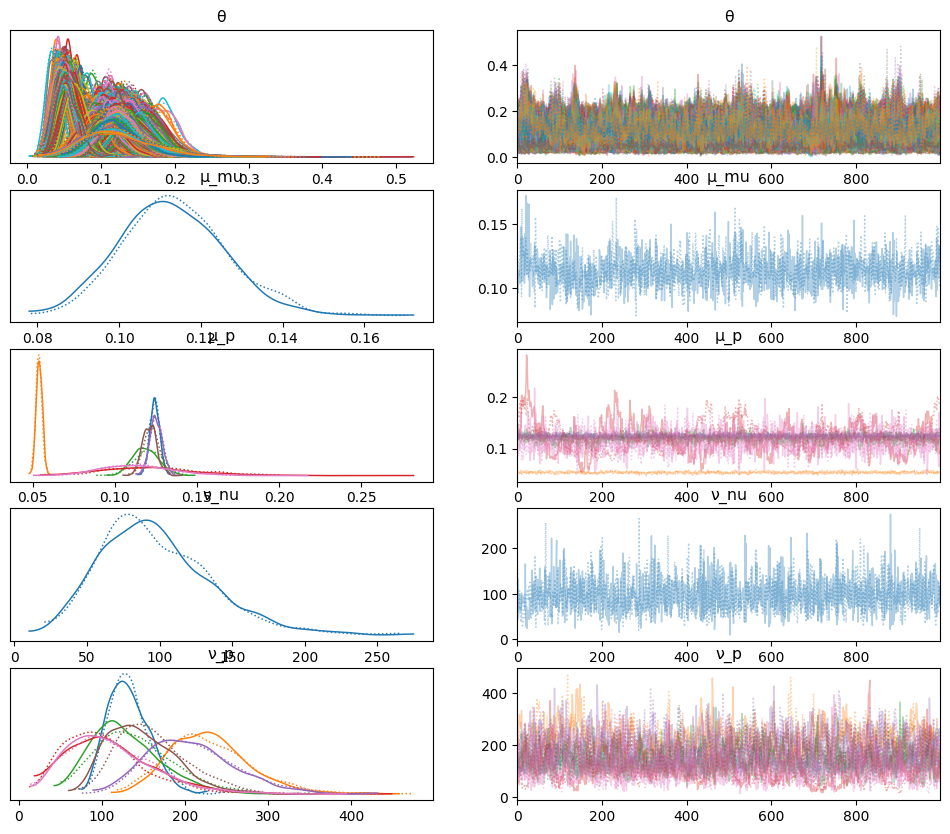

In [14]:
az.plot_trace(idata_hockey_h)

In [15]:
az.rhat(idata_hockey_h)

<xarray.Dataset> Size: 17kB
Dimensions:  (θ_dim_0: 1022, Pos: 7)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 8kB 0 1 2 3 4 5 6 ... 1016 1017 1018 1019 1020 1021
  * Pos      (Pos) <U2 56B 'C' 'D' 'F' 'G' 'LW' 'RW' 'W'
Data variables:
    θ        (θ_dim_0) float64 8kB 0.9997 0.9999 0.9991 ... 1.004 1.002 1.007
    μ_mu     float64 8B 1.002
    μ_p      (Pos) float64 56B 1.002 1.004 1.009 1.016 1.004 1.006 1.002
    ν_nu     float64 8B 1.001
    ν_p      (Pos) float64 56B 1.002 1.004 1.013 1.028 1.0 1.028 1.001

In [16]:
az.rhat(idata_hockey_h).μ_p

<xarray.DataArray 'μ_p' (Pos: 7)> Size: 56B
array([1.00166603, 1.0036111 , 1.00877845, 1.01622764, 1.00363099,
       1.00649005, 1.0015398 ])
Coordinates:
  * Pos      (Pos) <U2 56B 'C' 'D' 'F' 'G' 'LW' 'RW' 'W'

In [17]:
az.rhat(idata_hockey_h).ν_p

<xarray.DataArray 'ν_p' (Pos: 7)> Size: 56B
array([1.00242127, 1.00412434, 1.01257393, 1.02819143, 1.00003961,
       1.02793005, 1.00066947])
Coordinates:
  * Pos      (Pos) <U2 56B 'C' 'D' 'F' 'G' 'LW' 'RW' 'W'

array([<Axes: >], dtype=object)

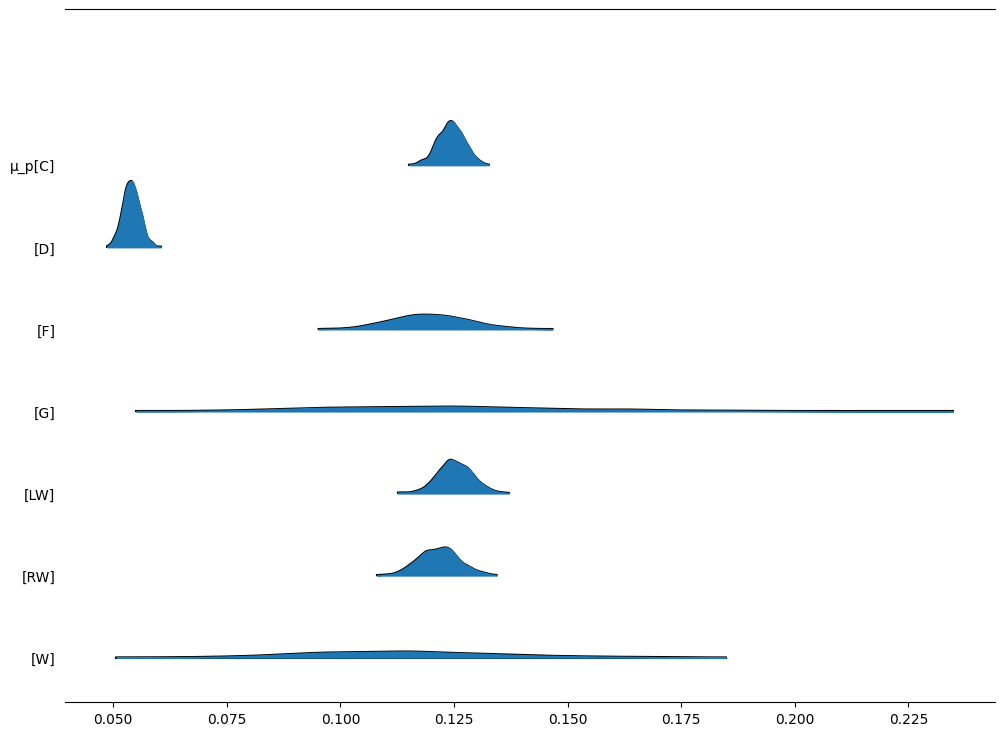

In [23]:
az.plot_forest(idata_hockey_h, var_names=['μ_p'], combined=True, figsize=(12, 9), kind = 'ridgeplot', hdi_prob=0.998)

# Comparison

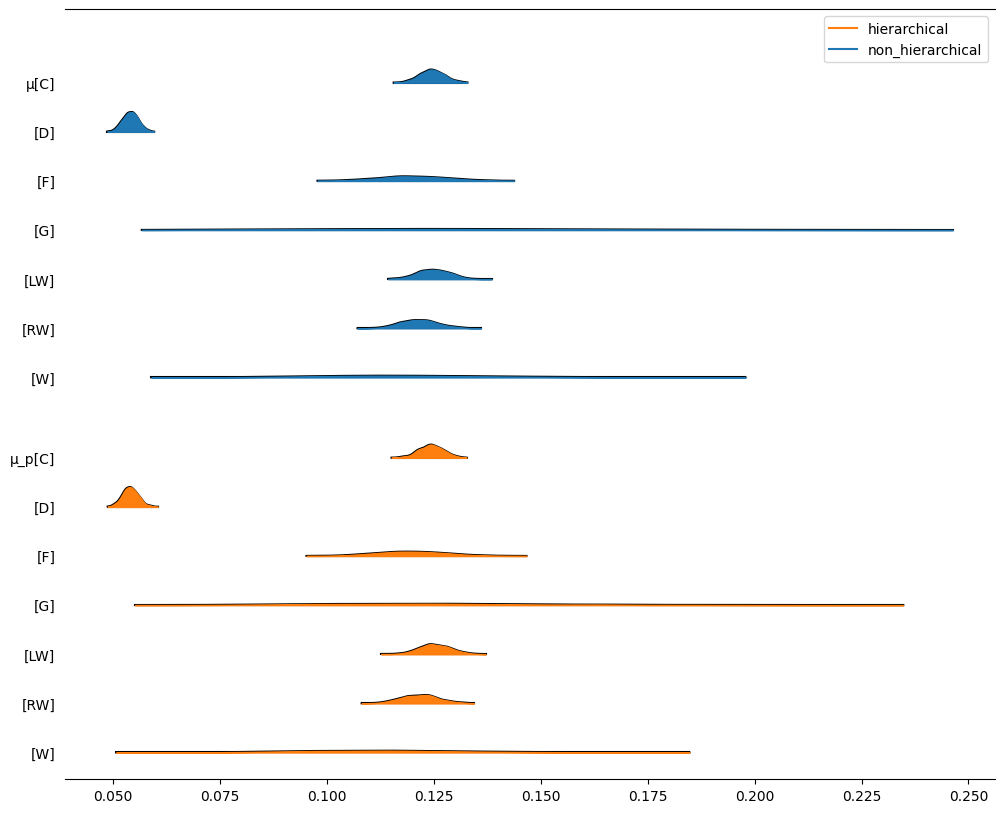

In [35]:
axes = az.plot_forest([idata_hockey_nh, idata_hockey_h], kind="ridgeplot",
                      model_names=['non_hierarchical', 'hierarchical'],
                      var_names=['μ', 'μ_p'] , combined=True, figsize=(12, 10),hdi_prob=0.998)

# Analysis

All of my rhat values were "good" values to have, implying that my results are pretty accurate based on the data that was given.

When looking at center, right wing, and left wing positions on the forest plot, the variance and mean are quite similar which makes sense considering they are all offensive positions. On average, around 1/8 of the shots made by these players will result in a goal.

Defenders also have little variance but their mean is much lower. This makes sense as defensive players will focus on keeping their own goal protected, their focus isn't on scoring goals.

Forwards have an increased variance, which I found very interesting. I am not really sure why the variance would be spread, maybe forwards are just overall not consistent players.

Goalkeeper variance is incredibly wide. I think this is attributed to the fact that goalkeepers are almost never the ones actually scoring the goals.

Most often, wingers are split between right wingers and left wingers. However, for the 24-25 NHL season, there were two players just designated as wingers with no specification between right and left. This accounts for the wide variance and low predictability of their goal percentages.

It is evident that there isn't *much* of a difference between hierarchical and non-hierarchical models. So I am not really sure which would be better to analyze the data.